## POI PUBBLICI

In [1]:
%reset -f

POI totali (prima dei filtri): 198
POI filtrati: 107 — Archi rete: 7258
POI nel DataFrame: 107


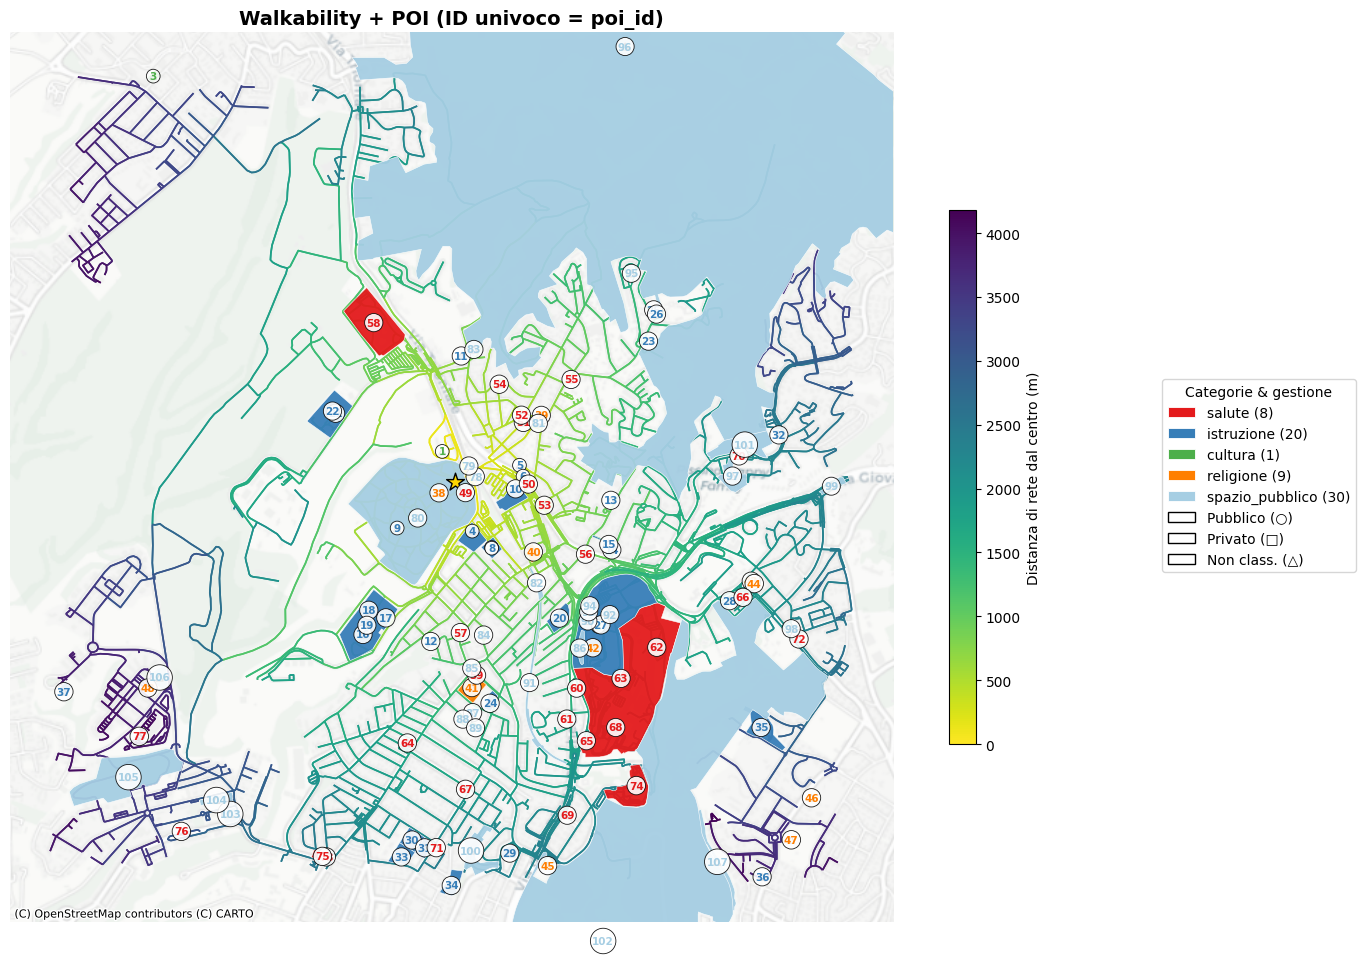

In [2]:
# =========================
# Config & Import
# =========================
# Parametri
CENTER_LATLON = (41.940583, 12.418912)  # Santa Maria della Pietà
DIST_M = 2000                            # raggio di ricerca
CRS_METRIC = "EPSG:32633"                # UTM 33N (Roma)
NETWORK_TYPE = "walk"                    # rete pedonale
USE_BASEMAP = True

# Categorie OSM da includere (amenity/leisure/shop/office)
POI_TAGS = {
    "amenity": [
        # istruzione
        "school", "university", "library", "college", "kindergarten",
        # salute
        "hospital", "clinic", "doctors", "pharmacy", "dentist", "nursing_home",
        # cultura
        "cinema", "theatre", "museum", "arts_centre", "community_centre",
        # religione
        "place_of_worship",
        # sport e wellness
        "sports_centre", "swimming_pool", "gym", "stadium", "pitch", "fitness_centre",
        # spazio pubblico
        "park", "public_bath", "social_centre", "youth_centre",
        # misti o privati
        "coworking_space", "wellness_centre", "spa", "private_clinic"
    ],
    "leisure": [
        "fitness_centre", "sports_centre", "stadium", "pitch", "swimming_pool", "sauna", "spa",
        "park", "garden", "recreation_ground"
    ],
    "shop": [
        "chemist", "health_food", "sports", "medical_supply"
    ],
    "office": [
        "educational_institution", "company", "health_insurance"
    ]
}

# Import
import warnings, numpy as np, geopandas as gpd, networkx as nx, matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.patches import Patch
import pandas as pd

warnings.filterwarnings("ignore")

import osmnx as ox           # fetch POI + rete
# import city2graph as c2g    # opzionale: KNN su network

# basemap opzionale
try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

# Impostazioni OSMnx
ox.settings.use_cache = True
ox.settings.timeout = 180

# Mappatura categorie → colori
CAT_ORDER = ["salute","istruzione","cultura","sport","religione","spazio_pubblico"]
COLOR_MAP = {
    "salute": "#e41a1c",
    "istruzione": "#377eb8",
    "cultura": "#4daf4a",
    "sport": "#984ea3",
    "religione": "#ff7f00",
    "spazio_pubblico": "#a6cee3",
}

def amenity_to_category(a: str) -> str:
    # SALUTE
    if a in {"hospital", "clinic", "private_clinic", "doctors", "pharmacy", "dentist", "nursing_home", "health_insurance", "medical_supply"}:
        return "salute"
    # ISTRUZIONE
    if a in {"school", "university", "college", "kindergarten", "library", "educational_institution"}:
        return "istruzione"
    # CULTURA
    if a in {"museum", "theatre", "cinema", "arts_centre", "community_centre", "social_centre", "youth_centre"}:
        return "cultura"
    # SPORT & WELLNESS
    if a in {"sports_centre", "swimming_pool", "gym", "stadium", "pitch", "fitness_centre", "spa", "sauna", "wellness_centre"}:
        return "sport"
    # RELIGIONE
    if a in {"place_of_worship"}:
        return "religione"
    # SPAZIO PUBBLICO / VERDE
    if a in {"park", "garden", "recreation_ground", "public_bath"}:
        return "spazio_pubblico"
    # ALTRO
    if a in {"coworking_space", "company", "chemist", "health_food", "sports"}:
        return "altro"
    return "altro"

# =========================
# 1) POI: download & pre-processing
# =========================
poi_gdf = ox.features_from_point(
    CENTER_LATLON,
    tags=POI_TAGS,
    dist=DIST_M,
)
poi_gdf = poi_gdf[poi_gdf.geometry.notna()].copy().to_crs(CRS_METRIC)

print(f"POI totali (prima dei filtri): {len(poi_gdf)}")

# --- TAG PRINCIPALE (amenity/leisure/shop/office) ---
def extract_main_tag(row):
    for k in ("amenity", "leisure", "shop", "office"):
        v = row.get(k, None)
        if isinstance(v, str) and v.strip():
            return k, v
    return None, None

poi_gdf[["tag_key","tag_val"]] = poi_gdf.apply(
    lambda r: pd.Series(extract_main_tag(r)), axis=1
)

# --- Categoria: usa amenity_to_category su tag_val ---
poi_gdf["category"] = poi_gdf["tag_val"].map(
    lambda a: amenity_to_category(a) if isinstance(a, str) else "altro"
)

# --- Stima pubblico/privato (vectorized, robusta) ---
for c in ["operator", "name"]:
    if c not in poi_gdf.columns:
        poi_gdf[c] = np.nan

poi_gdf["operator_norm"] = poi_gdf["operator"].fillna("").astype(str).str.lower()
poi_gdf["name_norm"]     = poi_gdf["name"].fillna("").astype(str).str.lower()

cond_pub   = poi_gdf["operator_norm"].str.contains(r"comune|pubblica|municipio", regex=True)
cond_pr_op = poi_gdf["operator_norm"].str.contains(r"\b(privato|srl|spa)\b", regex=True)
cond_pr_nm = poi_gdf["name_norm"].str.contains(r"\b(privata|private|srl|spa)\b", regex=True)

poi_gdf["pub_priv"] = np.select(
    [cond_pub, (cond_pr_op | cond_pr_nm)],
    ["pubblico", "privato"],
    default="non_classificato"
)

poi_gdf.drop(columns=["operator_norm","name_norm"], inplace=True)

# --- ID OSM stabile (fallback all'indice) ---
if "osmid" in poi_gdf.columns:
    poi_gdf["osm_id"] = poi_gdf["osmid"].astype(str)
else:
    poi_gdf = poi_gdf.reset_index()
    idx_cols = [c for c in poi_gdf.columns if c in ["osmid","id","element_type","element_id","index"]]
    if idx_cols:
        poi_gdf["osm_id"] = poi_gdf[idx_cols].astype(str).agg("-".join, axis=1)
    else:
        poi_gdf["osm_id"] = poi_gdf.index.astype(str)

CAT_FOR_ANALYSIS = [c for c in CAT_ORDER if c != "sport" and "spazio_pubblico"]

# Filtro categorie target (coerente con mappa/legenda)
poi_gdf = poi_gdf[poi_gdf["category"].isin(CAT_FOR_ANALYSIS)].copy()

# =========================
# 2) Rete pedonale + proiezione in CRS metrico
# =========================
G_ll = ox.graph_from_point(CENTER_LATLON, dist=DIST_M, network_type=NETWORK_TYPE, simplify=True)
center_node = ox.distance.nearest_nodes(G_ll, X=CENTER_LATLON[1], Y=CENTER_LATLON[0])
G = ox.project_graph(G_ll, to_crs=CRS_METRIC)

# GeoDataFrame archi
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# =========================
# 3) Distanze di rete dal centro (per colorare le strade)
# =========================
dist = nx.single_source_dijkstra_path_length(G, center_node, weight="length")
for u, v, k, data in G.edges(keys=True, data=True):
    du = dist.get(u, np.nan)
    dv = dist.get(v, np.nan)
    data["dist_edge_m"] = np.nanmin([du, dv])
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# =========================
# 4) Punto centro (stella)
# =========================
center_gdf = gpd.GeoDataFrame(
    {"name": ["Centro"]},
    geometry=[Point(CENTER_LATLON[1], CENTER_LATLON[0])],
    crs="EPSG:4326"
).to_crs(CRS_METRIC)

print(f"POI filtrati: {len(poi_gdf)} — Archi rete: {len(edges_gdf)}")

# =========================
# 5) DataFrame ricco + punti rappresentativi
# =========================
def build_poi_dataframe(poi_gdf, G, center_gdf, dist_dict):
    """
    Output:
      - poi_df: DataFrame tabellare ricco (ordinamento deterministico + poi_id stabile)
      - poi_points: GeoSeries (CRS metrico) con il punto rappresentativo per label/nearest-node
    """
    if poi_gdf.empty:
        return pd.DataFrame(), gpd.GeoSeries([], crs=poi_gdf.crs)

    # 1) punto rappresentativo per poligoni / punto per i points
    geom = poi_gdf.geometry
    is_poly = geom.geom_type.isin(["Polygon","MultiPolygon"])
    rep_points = geom.copy()
    rep_points[is_poly] = geom[is_poly].representative_point()
    poi_points = gpd.GeoSeries(rep_points, crs=poi_gdf.crs)

    # 2) nearest node su grafo proiettato (vectorized)
    nn = ox.distance.nearest_nodes(G, X=poi_points.x.values, Y=poi_points.y.values)

    # 3) distanza di rete dal centro (m)
    net_dist = [dist_dict.get(n, np.nan) for n in nn]

    # 4) distanza euclidea (m) dal centro geometrico
    center_pt = center_gdf.geometry.iloc[0]
    eucl_dist = poi_points.distance(center_pt)

    # 5) base informativa
    base = poi_gdf.reset_index(drop=True).copy()
    base["geometry_type"]   = poi_gdf.geometry.geom_type.values
    base["x"]               = poi_points.x.values
    base["y"]               = poi_points.y.values
    base["eucl_dist_m"]     = eucl_dist.values
    base["net_dist_m"]      = net_dist

    # campi comuni se mancanti
    for c in ["name","addr:street","addr:housenumber","addr:city","opening_hours","phone","website",
              "operator","brand","wikidata","wikipedia","tag_key","tag_val","osm_id","pub_priv","amenity","category"]:
        if c not in base.columns:
            base[c] = np.nan

    # 6) ordinamento deterministico e poi_id stabile (1..N)
    base["category"] = base["category"].astype("category")
    sort_cols = [c for c in ["category","net_dist_m","tag_key","tag_val","name","osm_id"] if c in base.columns]
    base = base.sort_values(sort_cols, na_position="last").reset_index(drop=True)
    base.insert(0, "poi_id", np.arange(1, len(base)+1))

    # 7) colonne d'interesse
    cols_order = [
        "poi_id","name","tag_key","tag_val","amenity","category","pub_priv","geometry_type",
        "addr:street","addr:housenumber","addr:city",
        "opening_hours","phone","website","operator","brand","wikidata","wikipedia",
        "eucl_dist_m","net_dist_m","x","y","osm_id"
    ]
    cols_order = [c for c in cols_order if c in base.columns]
    poi_df = base[cols_order].copy()
    return poi_df, poi_points

# calcolo
poi_df, poi_points = build_poi_dataframe(poi_gdf, G, center_gdf, dist)
print(f"POI nel DataFrame: {len(poi_df)}")

# =========================
# 6) (Opzionale) Grafo KNN su network distance
# =========================
# knn_nodes, knn_edges = c2g.knn_graph(
#     poi_gdf,
#     k=8,
#     distance_metric="network",
#     network_gdf=edges_gdf.to_crs(CRS_METRIC),
# )
# print(f"KNN edges: {len(knn_edges)}")

# =========================
# 7) Plot mappa: strade colorate + POI con ID univoco e marker pub/priv
# =========================
fig, ax = plt.subplots(figsize=(11.5, 9.5))

# A) Basemap
if USE_BASEMAP and HAS_CTX:
    try:
        edges_gdf.plot(ax=ax, color="none")
        ctx.add_basemap(ax, crs=CRS_METRIC, source=ctx.providers.CartoDB.Positron)
    except Exception:
        pass

# B) Strade colorate per distanza
edges_plot = edges_gdf.sort_values("dist_edge_m")
edges_plot.plot(
    ax=ax, column="dist_edge_m", cmap="viridis_r",
    linewidth=1.2, legend=True,
    legend_kwds={"label": "Distanza di rete dal centro (m)", "shrink": 0.6},
    zorder=2
)

# C) POI poligonali (riempimento per categoria)
poi_polygons = poi_gdf[poi_gdf.geometry.geom_type.isin(["Polygon","MultiPolygon"])].copy()
handles = []
if not poi_polygons.empty:
    counts = poi_polygons["category"].value_counts().to_dict()
    for cat in CAT_ORDER:
        if cat not in COLOR_MAP:
            continue
        sub = poi_polygons[poi_polygons["category"] == cat]
        if sub.empty:
            continue
        sub.plot(
            ax=ax,
            color=COLOR_MAP.get(cat, "#7f7f7f"),
            edgecolor="white",
            linewidth=0.4,
            alpha=0.95,
            zorder=3
        )
    handles = [
        Patch(facecolor=COLOR_MAP[c], edgecolor='white', linewidth=0.6,
              label=f"{c} ({counts.get(c, 0)})")
        for c in CAT_ORDER if counts.get(c, 0) > 0
    ]

# D) Centro (stella dorata)
center_gdf.plot(ax=ax, color='gold', edgecolor='black', markersize=180, marker='*', zorder=4)

# E) Marker per TUTTI i POI + etichette = poi_id
poi_plot = poi_df.copy()
marker_map = {"pubblico": "o", "privato": "s", "non_classificato": "^"}
sizes_map  = {"pubblico": 28,  "privato": 28,  "non_classificato": 26}

for status in ["pubblico","privato","non_classificato"]:
    sub = poi_plot[poi_plot["pub_priv"] == status]
    if not sub.empty:
        ax.scatter(
            sub["x"], sub["y"],
            s=sub["pub_priv"].map(sizes_map),
            marker=marker_map[status],
            facecolors="none", edgecolors="black", linewidths=0.7, zorder=5, label=None
        )

# Etichette numeriche = poi_id per tutti
for _, row in poi_plot.iterrows():
    ax.text(
        row["x"], row["y"], str(int(row["poi_id"])),
        fontsize=7.5, weight="bold",
        color=COLOR_MAP.get(row.get("category","altro"), "black"),
        ha="center", va="center",
        bbox=dict(boxstyle="circle,pad=0.18", fc="white", ec="black", lw=0.6, alpha=0.9),
        zorder=6
    )

# Layout finale
ax.set_title("Walkability + POI (ID univoco = poi_id)", fontsize=14, fontweight="bold")
ax.set_aspect("equal")
ax.axis("off")

# Legende
extra_handles = [
    Patch(facecolor="none", edgecolor="black", label="Pubblico (○)"),
    Patch(facecolor="none", edgecolor="black", label="Privato (□)"),
    Patch(facecolor="none", edgecolor="black", label="Non class. (△)")
]
if handles:
    fig.legend(handles=handles + extra_handles, loc="center left",
               bbox_to_anchor=(1.02, 0.5), frameon=True, title="Categorie & gestione")
else:
    fig.legend(handles=extra_handles, loc="center left",
               bbox_to_anchor=(1.02, 0.5), frameon=True, title="Gestione")

plt.tight_layout()
plt.show()


# Export opzionali
# catalogo.to_csv("poi_catalogo.csv", index=False)
# catalogo.to_html("poi_catalogo.html", index=False)


In [3]:
# =========================
# 8) Catalogo: tabella pronta a filtri/ricerche + export opzionale
# =========================
cols_catalogo = ["poi_id","name","tag_key","tag_val","category","pub_priv",
                 "addr:street","addr:housenumber","addr:city",
                 "net_dist_m","eucl_dist_m","osm_id","website","phone","opening_hours"]
cols_catalogo = [c for c in cols_catalogo if c in poi_df.columns]
catalogo = poi_df[cols_catalogo].copy()
catalogo["net_dist_m"]  = catalogo["net_dist_m"].round(1)
catalogo["eucl_dist_m"] = catalogo["eucl_dist_m"].round(1)

print(catalogo.head(50))


    poi_id                                               name  tag_key  \
0        1                                       Park of kids  amenity   
1        2                                         Auditorium  amenity   
2        3                                           Starplex  amenity   
3        4     Scuola Maria Grazia Amici e Filomena di Meglio  amenity   
4        5                                  Scuola elementare  amenity   
5        6                                         Don Orione  amenity   
6        7                    Scuola Materna Leonardo Bianchi  amenity   
7        8                  Scuola paritaria - Scuola Materna  amenity   
8        9  Montemario international art arte e comunicazione  amenity   
9       10  Istituto Tecnico Industriale Statale Enrico Fermi  amenity   
10      11                    Asilo Nido Il Nido di Peter Pan  amenity   
11      12                                                NaN  amenity   
12      13                            